# COVID-19 cases in Poços de Caldas

A repo for coronavirus related case count data from Poços de Caldas, MG, Brazil.

In [1]:
import pandas as pd
from matplotlib.dates import DateFormatter
from os import path
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import_from_web = True

# get data from the Healthy Department of the State of Minas Gerais
if import_from_web:
    try:
        df = pd.read_csv('https://www.saude.mg.gov.br/images/noticias_e_eventos/000_2020/coronavirus-dados-csv/notificacoes-covid19-mg.csv',
                         encoding = "ISO-8859-1",
                         dayfirst=True, 
                         sep=';',
                         parse_dates =['DATA_NOTIFICACAO', 'DATA_ATUALIZACAO']
                        )
        df.to_csv(path.join('data', 'notificacoes-covid19-mg.csv'))
        
    except:
        print('Error: unable to update the file.')


df = pd.read_csv(path.join('data', 'notificacoes-covid19-mg.csv'),
                     dayfirst=True,
                     parse_dates =['DATA_NOTIFICACAO', 'DATA_ATUALIZACAO']
                    )

# filtering the data related to Poços de Caldas
city = 'POÇOS DE CALDAS'
df_city = df[df['MUNICIPIO_RESIDENCIA'] == city].sort_values(by=['DATA_NOTIFICACAO']).reset_index().drop(['index'], axis=1)

## Confirmed Cases - State Dataset

In [2]:
# organizing the data
df_conf = df_city['DATA_NOTIFICACAO'].value_counts().rename_axis(['DATA_NOTIFICACAO']).reset_index(name='NOVOS_CASOS').sort_values('DATA_NOTIFICACAO')
df_conf = df_conf.reset_index().drop(['index'], axis=1)

# add cumulative cases column
df_conf['CONFIRMADOS'] = df_conf['NOVOS_CASOS'].cumsum()

# exporting a csv file
df_conf.to_csv(path.join('data', 'PC-COVID19-Total-Confirmed-Cases.csv'))

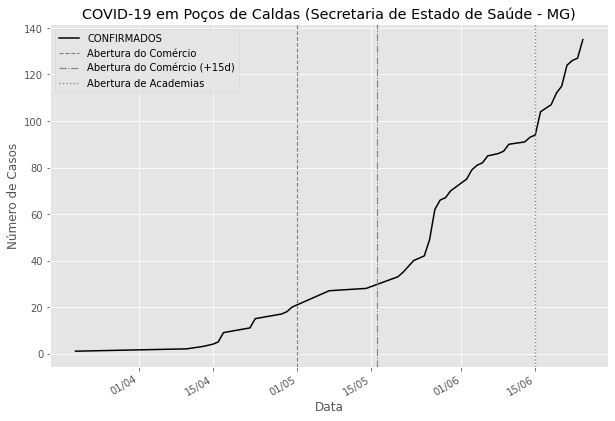

In [3]:
plt_conf = df_conf.plot.line(x='DATA_NOTIFICACAO',y='CONFIRMADOS',color="black",
                                              figsize=(10,7))

plt_conf.axvline("2020-05-01",label='Abertura do Comércio',  color="gray", lw=1.1, linestyle="--")
plt_conf.axvline("2020-05-16",label='Abertura do Comércio (+15d)', color="gray", lw=1.1, linestyle="-.")
plt_conf.axvline("2020-06-15",label='Abertura de Academias', color="gray", lw=1.3, linestyle=":")

plt_conf.xaxis.set_major_formatter(DateFormatter('%d/%m'))
plt_conf.set_ylabel("Número de Casos")
plt_conf.set_xlabel("Data")
plt_conf.set_title("COVID-19 em Poços de Caldas (Secretaria de Estado de Saúde - MG)")
plt_conf.legend()
plt_conf.get_figure().savefig(path.join('results','graph_confirmed_cases.png'), bbox_inches='tight')

## Confirmed Cases - State Dataset

In [19]:
from cov19.dataset import region_dataset
from cov19.stat   import *
from cov19.models import *

import pandas as pd
from matplotlib.dates import DateFormatter
from os import path
import matplotlib.pyplot as plt
plt.style.use('ggplot')


df_bol = pd.read_csv(path.join('data', 'PC_boletins_data.csv'),
                     dayfirst=True,
                     parse_dates =['Data']
                    )

df_bol['Infectados'] = df_bol['Confirmados']-df_bol['Recuperados']-df_bol['Óbitos']


In [100]:
db_c19 = region_dataset(
            data = df_bol,
            name = 'Poços de Caldas',
            population = 150000,
            time_col = 'Data',
            confirmed_col = 'Confirmados',
            actives_col   = 'Infectados',
            deaths_col    = 'Óbitos',
            recovered_col = 'Recuperados'
        )



StatModel = stat_model(db_c19,
                       mod_sird,
                       [0.84386702, 0.1874707 , 0.124, 0.00642724, 3.62905556],
                       rescaling_by = 1,
                       par_labels   = ["α","β","ρ","δ","logS0"]
                       )

[info]: Defining statistical model.


In [160]:
c_data = StatModel.dataframe.confirmed_list 
c_len = len(c_data[c_data  != 0])

r_data = StatModel.dataframe.recovered_list
r_len = len(r_data [r_data  != 0])

d_data = StatModel.dataframe.death_list
d_len = len(d_data [d_data  != 0])

factor = 1/(1/c_len+1/r_len+1/d_len)
c_weight = factor/c_len
r_weight = factor/r_len
d_weight = factor/d_len

In [197]:
if True:
    StatModel.metropolis_hastings(
        overwrite = False,
        n_points  = 1000000,
        par_stp   = [0.01,0.1,0.004,1.0e-04,0.03],
        file_name = "data/mcmc-pc.csv"
       ,
    #     fit_recovered = False,
    #     fit_death     = True,
    #     fit_confirmed = True,
        weight_recovered = 1,
        weight_death = 1,
        weight_confirmed = 1
    )

[info]: Generating a mcmc sample by metropolis-hastings algorithm.


[wlkr1]: 100%|██████████| 1000000/1000000 [24:00<00:00, 694.33it/s]


In [198]:
StatModel.import_sample(file_name = "data/mcmc-pc.csv",
                        filter_outliers = True)

[info]: Reading mcmc sample file.


In [205]:
est = StatModel.single_parameter_estimates(
    alpha=0.3173,
    est_outfile = 'data/estimates.csv'
)
est

[info]: Evaluating statistical properties of sample.


,Parameters,Mean,Medians,1 sig interval min,1 sig interval max
α,α,0.966584,0.970936,0.927840,1.005740
β,β,0.107496,0.104104,0.088171,0.121483
ρ,ρ,0.051802,0.049883,0.024007,0.073989
δ,δ,0.005957,0.005926,0.005572,0.006355
logS0,logS0,3.113221,3.073534,3.017191,3.166963


In [206]:
(est['1 sig interval max']-est['1 sig interval min']).values

array([0.0779003 , 0.03331188, 0.04998278, 0.000783  , 0.1497712 ])

In [207]:
[0.84386702, 0.1874707 , 0.1245921 , 0.00642724, 3.62905556]

[0.84386702, 0.1874707, 0.1245921, 0.00642724, 3.62905556]

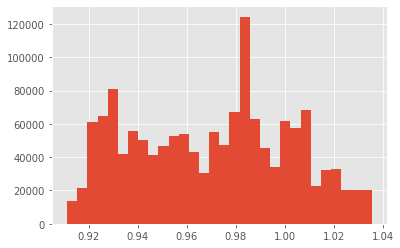

In [210]:
StatModel.sample_df.iloc[:,0].hist(bins=30)

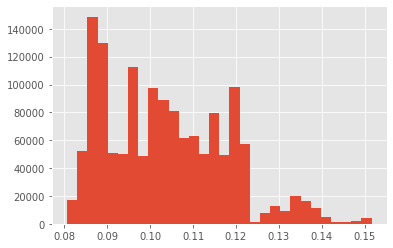

In [211]:
StatModel.sample_df.iloc[:,1].hist(bins=30)

1  ->  1031.6079652683122

[info]: Ploting epidemiological model curves with dataset.


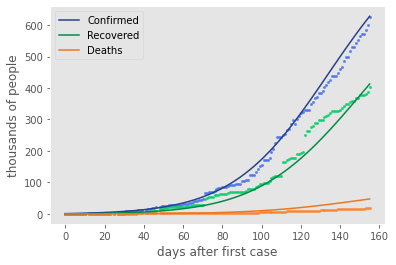

In [203]:
StatModel.data_model_plot(est['Mean'].values)

[info]: Ploting epidemiological model curves with dataset.


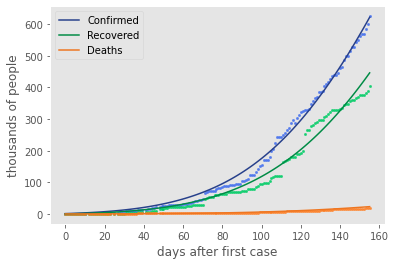

In [204]:
StatModel.data_model_plot([0.84386702, 0.1874707 , 0.1245921 , 0.00642724, 3.62905556])

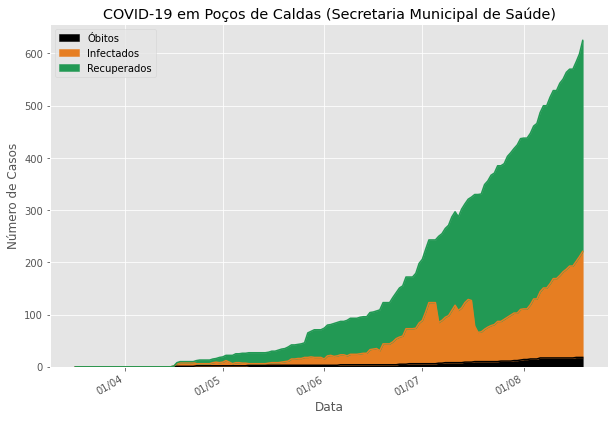

In [192]:
plt_bol = df_bol.plot.area(x='Data',y=['Óbitos','Infectados','Recuperados'],
                           color=["black","#E67E22","#229954"],
                           figsize=(10,7))

plt_bol.xaxis.set_major_formatter(DateFormatter('%d/%m'))
plt_bol.set_ylabel("Número de Casos")
plt_bol.set_xlabel("Data")
plt_bol.set_title("COVID-19 em Poços de Caldas (Secretaria Municipal de Saúde)")
plt_bol.legend()
plt_bol.get_figure().savefig('results/covid_cases_area_plot.png')

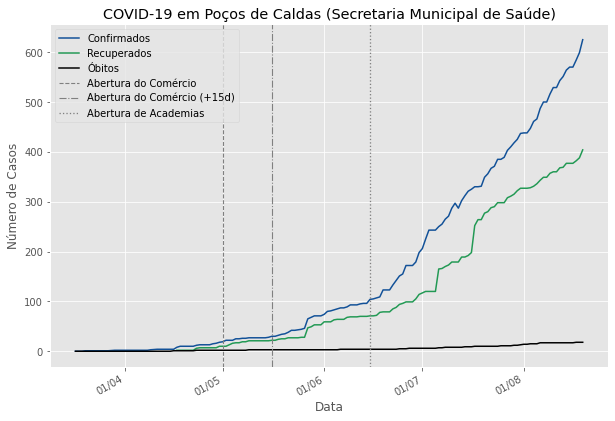

In [9]:
plt_bol = df_bol.plot.line(x='Data',y=['Confirmados','Recuperados','Óbitos'],color=["#125198","#229954","black"],
                                              figsize=(10,7))


plt_bol.axvline("2020-05-01",label='Abertura do Comércio',  color="gray", lw=1.1, linestyle="--")
plt_bol.axvline("2020-05-16",label='Abertura do Comércio (+15d)', color="gray", lw=1.1, linestyle="-.")
plt_bol.axvline("2020-06-15",label='Abertura de Academias', color="gray", lw=1.3, linestyle=":")

plt_bol.xaxis.set_major_formatter(DateFormatter('%d/%m'))
plt_bol.set_ylabel("Número de Casos")
plt_bol.set_xlabel("Data")
plt_bol.set_title("COVID-19 em Poços de Caldas (Secretaria Municipal de Saúde)")
plt_bol.legend()
plt_bol.get_figure().savefig('results/covid_cases_line_plot.png')